In [2]:
import sys
sys.path.append("..")

In [3]:
from squlearn.encoding_circuit.encoding_circuit_derivatives import *

import numpy as np
from scipy.integrate import odeint
from solvers.MMR.kernel_solver import Solver
from solvers.MMR.PQK_solver import PQK_solver
from solvers.MMR.FQK_solver import FQK_solver
from DE_Library.diferential_equation_functionals import *

from utils.rbf_kernel_tools import *
from circuits.circuits import *
import pandas as pd


import matplotlib.pyplot as plt

To run this notebook it is necessary to have installed my branch of squlearn installed

In [17]:
def loss_log_ode(f_array):
    """
    Defines the loss function for the ODE problem

    f_array is assumed to be [x, f, dfdx, dfdxdx]
    
    """
    x, f, dfdx, dfdxdx = f_array
    lamb = 1
    k = 1
    return dfdx - np.exp(-f*k)*lamb 


def grad_loss_log_ode(f_array):
    """
    n = x_span.shape[0] number of points
    m = x_span.shape[1] number of dimensions (typically m=1)

    F[x, x_, x__] = F(x, x_, x__)

    grad_F = (F(x, x_, x__)dx, F(x, x_, x__)dx_, F(x, x_, x__)dx__)

    F = lamb * np.exp(f * k) - df/dx

    grad_F = (-lamb*k, -1, 0)
    """
    x, f, dfdx, dfdxdx = f_array
    
    lamb, k = 1, 1

    dFdf = lamb*k*np.exp(-f*k)
    dFdfdx = 1
    dFdfdxdx = 0

    return [dFdf, dFdfdx, dFdfdxdx]

def derivatives_loss_log_ode(f_alpha_tensor, x_span = None):
    """
    0 = lamb * np.exp(f * k) - df/dx
    f(0.001) = np.log(0.001)

    solution: f(x) = np.log(x)
    """
    f = f_alpha_tensor[0]
    lamb = 1
    k = 1
    return [np.exp(-f*k)*lamb]


In [43]:
x_line = np.linspace(0.01, 0.9, 20)
f_initial = [np.log(x_line[0])]

#Exact result
f_exact = np.log(x_line)

#Numerical result
f_odeint = odeint(derivatives_loss_log_ode, f_initial, x_line[:]).flatten()


#Classical Solver
#RBF
RBF_kernel_list = [rbf_kernel_manual(x_line, x_line, sigma = 0.4), analytical_derivative_rbf_kernel(x_line, x_line, sigma = 0.4), analytical_derivative_rbf_kernel_2(x_line, x_line, sigma = 0.4)]
Solver_test = Solver(RBF_kernel_list, regularization_parameter=1)
solution_RBF, loss_by_iteration_RBF = Solver_test.solver(x_line, f_initial, L_functional = loss_log_ode)
f_RBF, optimal_alpha_RBF = solution_RBF 




#Quantum Solvers
#PQK
sigma_list = np.linspace(0.1, 1, 70)
mse_list = np.zeros_like(sigma_list)
sigma = 1.5


PQK_solver_test = PQK_solver({"encoding_circuit": Separable_rx_qiskit, 
                            "num_qubits": 8,
                            "num_layers": 2,
                            },
                            Executor("pennylane"), 
                            envelope={"function": rbf_kernel_manual, 
                                        "derivative_function": analytical_derivative_rbf_kernel, 
                                        "second_derivative_function": analytical_derivative_rbf_kernel_2,
                                        "sigma": sigma})


solution_PQK, loss_by_iteration_PQK = PQK_solver_test.solver(x_line, f_initial, L_functional = loss_log_ode)
f_PQK, optimal_alpha_PQK = solution_PQK

#FQK
FQK_solver_test = FQK_solver({"encoding_circuit": HardwareEfficientEmbeddingCircuit_qiskit, 
                              "num_qubits": 7, #7
                              "num_layers": 2,
                              },
                              Executor("pennylane"),)
solution_FQK, loss_by_iteration_FQK = FQK_solver_test.solver(x_line, f_initial, loss_log_ode)
f_FQK, optimal_alpha_FQK = solution_FQK

-0.0
0.2907625998020323
0.569685151568648
0.8257275231749858
1.0493740968263097
1.2332168092337945
1.372347215333708
1.4645302934126618
1.5101570392292054
1.511996129593349
1.4747841326798934
1.4047067473284947
1.3088292648064928
1.1945328889731526
1.0690057568892826
0.9388252402255327
0.8096535249327405
0.6860537154724229
0.5714206305432799
0.4680103572152104
-0.2907625998020323
-0.0
0.29076259980203223
0.569685151568648
0.8257275231749859
1.0493740968263099
1.2332168092337943
1.372347215333708
1.4645302934126618
1.5101570392292054
1.511996129593349
1.4747841326798934
1.4047067473284949
1.3088292648064928
1.1945328889731526
1.0690057568892826
0.9388252402255327
0.8096535249327405
0.6860537154724229
0.5714206305432799
-0.569685151568648
-0.29076259980203223
-0.0
0.2907625998020323
0.5696851515686481
0.825727523174986
1.0493740968263097
1.2332168092337945
1.372347215333708
1.4645302934126616
1.5101570392292056
1.511996129593349
1.4747841326798936
1.4047067473284949
1.3088292648064928
1.

In [44]:
def get_full_loss(functional_loss_by_iteration, y_exact):
    return np.mean((np.array(functional_loss_by_iteration)-y_exact)**2, axis = 1)

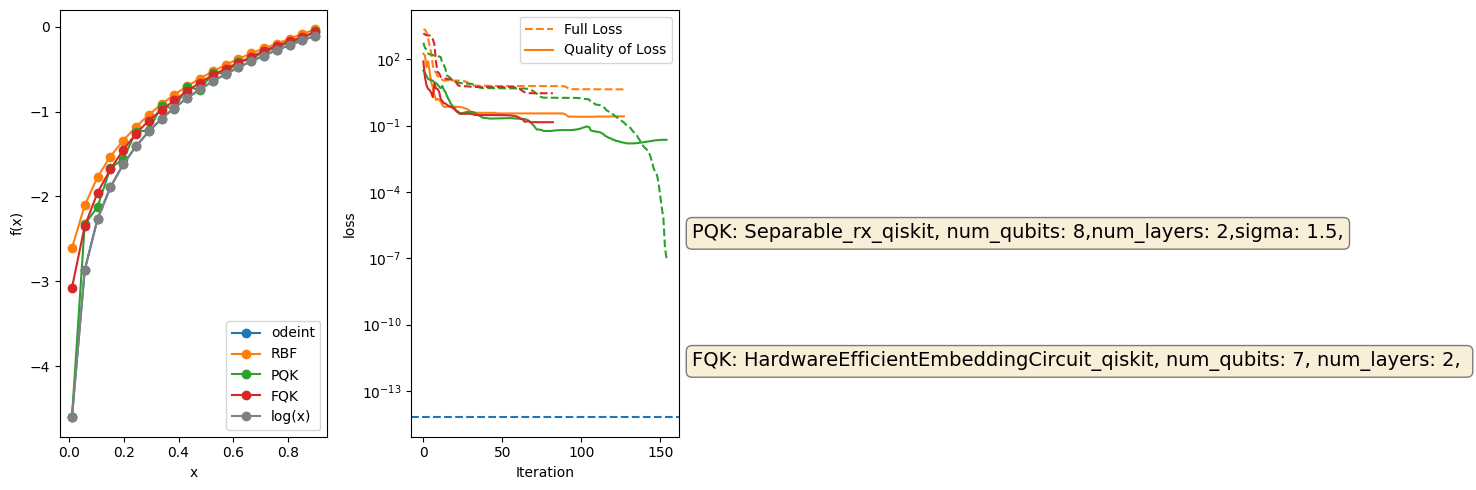

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


x_span_plot = x_line.reshape(-1, 1)
ax1.plot(x_span_plot, f_odeint, "-o", label="odeint", color="C0")
ax1.plot(x_span_plot, f_RBF, "-o", label="RBF", color="C1")
ax1.plot(x_span_plot, f_PQK, "-o",label="PQK", color="C2")
ax1.plot(x_span_plot, f_FQK, "-o", label="FQK", color="C3")
ax1.plot(x_span_plot, f_exact, "-o", label="log(x)", color="gray")


ax1.set_ylabel("f(x)")
ax1.set_xlabel("x")
ax1.legend()

str_PQK_info = PQK_solver_test.print_plotting_relevant_info()
str_FQK_info = FQK_solver_test.print_plotting_relevant_info()

#ax2 is for the errors
ax2.plot(loss_by_iteration_RBF[0], color="C1", linestyle="--", label="Full Loss")
ax2.plot(get_full_loss(loss_by_iteration_RBF[1], f_exact), color="C1", label="Quality of Loss")

ax2.plot(loss_by_iteration_PQK[0], color="C2", linestyle="--",)
ax2.plot(get_full_loss(loss_by_iteration_PQK[1], f_exact), color="C2", )

ax2.plot(loss_by_iteration_FQK[0], color="C3", linestyle="--", )
ax2.plot(get_full_loss(loss_by_iteration_FQK[1], f_exact), color="C3", )

ax2.axhline(np.mean((f_odeint-f_exact)**2), color="C0", linestyle="--")

ax2.set_yscale("log")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("loss")

ax2.legend()


#add a txt box with the relevant info to the right of the plot
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax2.text(1.05, 0.5, str_PQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(1.05, 0.2, str_FQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


In [13]:
params_ini_for_qnn_log = np.array([-0.8668401 ,  0.62015684, -2.15667028, -0.95454592, -2.89136728,
       -1.92620405, -2.42505116, -0.73693033,  0.15005287,  0.11193568,
       -0.05050098,  0.1663773 , -1.60720058,  2.65320097, -2.67566268,
        1.73276216, -0.50043699, -0.0168493 , -2.00266291, -1.08206438,
        1.86698375,  3.38838397, -1.28013607,  0.40042087,  2.48657952,
        1.84133399, -2.57681948, -2.25447227, -1.48390435,  2.34203517,
       -3.05758795,  0.07006922,  2.83425198,  0.51826963,  0.283995  ,
       -1.27784187,  1.79961911,  1.75086033, -2.58554971,  2.22307143,
        3.21987049,  1.26645828, -1.5382721 ,  0.61663127, -2.49837747,
        0.67758954,  1.76342976,  0.28877661, -0.44080463, -2.08639276,
       -3.71336053,  0.42384569, -1.3393165 ,  0.12151889,  0.26585592,
       -3.43308924,  0.83359602, -2.13203627,  0.78660411,  0.28519979,
       -2.34090764, -0.64527869,  0.51750895, -0.32511686, -3.35527718,
        0.22554386,  1.28212405,  0.09355113,  1.97205487,  0.54384149,
        1.71538417, -2.27781413, -2.78838724,  1.93139642, -1.72878695,
       -2.10264181,  2.15244049, -0.95651545,  1.62222138,  1.41998766])

In [33]:
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor
from squlearn.qnn.lowlevel_qnn import LowLevelQNN
from squlearn.optimizers import SLSQP, Adam
from squlearn.qnn.loss import *
from squlearn.qnn.training import *
#from DE_Library.qnn_and_kernels_wrappers import ODELoss_wrapper
from DE_Library.diferential_equation_functionals import ODELoss_wrapper

x_line = np.linspace(0.01, 0.9, 20)


num_qubits = 4
num_features = 1
num_layers = 3
#circuit = YZ_CX_EncodingCircuit(num_qubits, num_features, num_layers)
circuit = ChebyshevTowerAndHEE(num_qubits, num_features, num_layers)
executor = Executor("pennylane")

Observables = SummedPaulis(num_qubits, include_identity=False)                                                      
param_obs = Observables.generate_initial_parameters(seed=1)
#param_ini = params_ini_for_qnn_log
param_ini = circuit.generate_initial_parameters(seed=1)


maxiter = 250

slsqp = SLSQP(options={"maxiter": 150, "ftol": 0.05})
log_file = "logarithm_DE.log"
adam = Adam(options={"maxiter": maxiter, "tol": 0.00009, "log_file": log_file })

initial_value = np.array([np.log(0.01)])
loss_ODE = ODELoss_wrapper(loss_log_ode, grad_loss_log_ode, initial_vec = initial_value, eta=1)


clf = QNNRegressor(
    circuit,
    Observables,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = False, #Parametrized Observables not benchmarked yet
)

In [34]:
y_ODE = np.zeros((x_line.shape[0]))
clf._fit(x_line, y_ODE,  weights=None)
f_QNN = clf.predict(x_line)


PARAM [-1.04273224  2.76867924 -6.28174803 -2.48396215 -4.43899639 -5.1228243
 -3.94257046 -1.94074114 -1.29725818  0.48778547 -1.01543168  2.32753689
 -3.71396256  4.75156384 -5.93902266  2.14215791 -1.0391785   0.73751814
 -4.51903101 -3.79376858  3.77926771  5.8843485  -2.34458092  2.41679727
  4.72984558  4.95877358 -5.21448823 -5.79240843 -4.14903331  4.75187884
 -5.04732254 -0.99139082  5.75400954  0.41676726  2.41119893 -2.31829895]
INPUT [0.01       0.05684211 0.10368421 0.15052632 0.19736842 0.24421053
 0.29105263 0.33789474 0.38473684 0.43157895 0.47842105 0.52526316
 0.57210526 0.61894737 0.66578947 0.71263158 0.75947368 0.80631579
 0.85315789 0.9       ]
LOSS 705.0293907172178
fit:   0%|          | 0/1 [05:50<?, ?it/s]
(array([0.01      , 0.05684211, 0.10368421, 0.15052632, 0.19736842,
       0.24421053, 0.29105263, 0.33789474, 0.38473684, 0.43157895,
       0.47842105, 0.52526316, 0.57210526, 0.61894737, 0.66578947,
       0.71263158, 0.75947368, 0.80631579, 0.85315789, 0

In [35]:
loss_qnn_df = pd.read_csv(log_file, delim_whitespace=True)

In [36]:
loss_qnn_df

,Iteration,f(x),Gradient,Step,Eff.,LR,LR.1
0,1,705.02939,1419.86134,0.28284,0.05000,0.05,NaN
1,2,429.96132,1140.05169,0.34468,0.03712,0.05,NaN
2,3,196.73823,643.08438,0.26569,0.03180,0.05,NaN
3,4,106.42247,403.17722,0.22727,0.02886,0.05,NaN
4,5,61.10906,278.49059,0.20530,0.02703,0.05,NaN
...,...,...,...,...,...,...,...
245,246,7.60091,1.72146,0.01503,0.04784,0.05,NaN
246,247,7.57960,1.67021,0.01469,0.04787,0.05,NaN
247,248,7.55953,1.62284,0.01436,0.04789,0.05,NaN
248,249,7.54061,1.57954,0.01403,0.04791,0.05,NaN


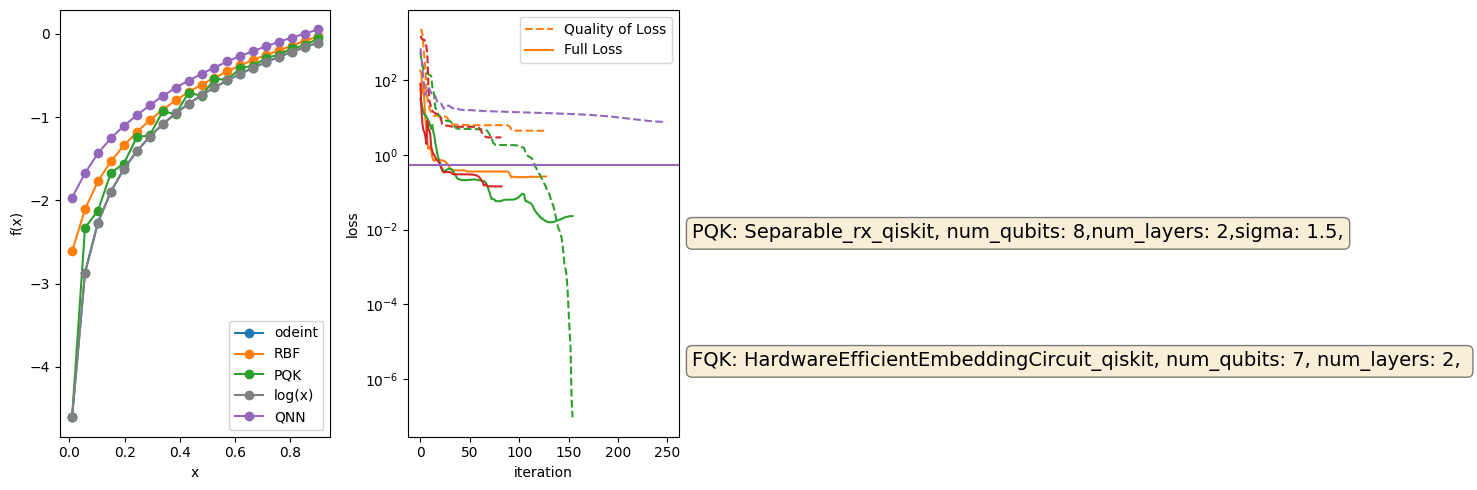

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


x_span_plot = x_line.reshape(-1, 1)
ax1.plot(x_span_plot, f_odeint,"-o", label="odeint", color="C0")
ax1.plot(x_span_plot, f_RBF, "-o", label="RBF", color="C1")
ax1.plot(x_span_plot, f_PQK, "-o", label="PQK", color="C2")
#ax1.plot(x_span_plot, f_FQK, "-o", label="FQK", color="C3")
ax1.plot(x_span_plot, np.log(x_span_plot),  "-o", label="log(x)", color="gray")
ax1.plot(x_span_plot, f_QNN, "-o", label="QNN", color="C4")
#plt.ylim(-3, 3)


ax1.set_ylabel("f(x)")
ax1.set_xlabel("x")
ax1.legend()

str_PQK_info = PQK_solver_test.print_plotting_relevant_info()
str_FQK_info = FQK_solver_test.print_plotting_relevant_info()

#ax2 is for the errors
ax2.plot(loss_by_iteration_RBF[0], color="C1", linestyle="--", label="Quality of Loss")
ax2.plot(get_full_loss(loss_by_iteration_RBF[1], f_exact),  color="C1", label="Full Loss")

ax2.plot(loss_by_iteration_PQK[0], color="C2", linestyle="--",)
ax2.plot(get_full_loss(loss_by_iteration_PQK[1], f_exact), color="C2", )

ax2.plot(loss_by_iteration_FQK[0], color="C3", linestyle="--", )
ax2.plot(get_full_loss(loss_by_iteration_FQK[1], f_exact), color="C3", )

if len(loss_qnn_df["f(x)"]) >= 5: #If 
        ax2.plot(loss_qnn_df["f(x)"], color="C4", linestyle="--", )
else:
        ax2.axhline(loss_qnn_df["f(x)"].iloc[-1], color="C4", linestyle="--", ) #Quality of Loss in QNN

ax2.axhline(np.mean((f_QNN.flatten()-f_exact)**2), color="C4", linestyle="-")



ax2.set_ylabel("loss")
ax2.set_xlabel("iteration")
ax2.set_yscale("log")
ax2.legend()

#add a txt box with the relevant info to the right of the plot
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax2.text(1.05, 0.5, str_PQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(1.05, 0.2, str_FQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()
